In [1]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img import images
from my_libs.img.camshift import *
from my_libs.img.processing import *
from my_libs.img.camshift import CamShift
from my_libs.img.background_subtraction import BackGroundSubtraction
from my_libs.img.video import get_frames

In [3]:
ml.tools.printf("Hello world!")

Hello world!

# Cvičení 10

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os
import time

1)  Segmentujte video (`pvi_cv10_video_in.mp4`) libovolným  funkčním segmentačním algoritmem.  
 
2)  V  každém  video  segmentu  detekujte  pohybující  se  objekty  pomocí algoritmu  CamShift  nebo  Background  Subtraction.  Detekované  objekty označte ve  snímcích obdélníkem. 
 
3) Naprogramujte vlastní algoritmy pro segmentaci, Background Subtraction a  CamShift.  Pro  CamShift  můžete  použít  vzor (`pvi_cv10_vzor_pomeranc.bmp`). 
 
4) Výsledné snímky (s  detekcí) poskládejte do nového video souboru se snímkovací frekvencí 10 snímků/s. 
 
help: 
```python
cap = cv2.VideoCapture('pvi_cv10_video_in.mp4') 

while True: 
    ret, bgr = cap.read() 

out = cv2.VideoWriter(... 
out.write(bgr) 
```

In [5]:
folder = 'data/'
video_file = "pvi_cv10_video_in.mp4"
template_file = "pvi_cv10_vzor_pomeranc.bmp"

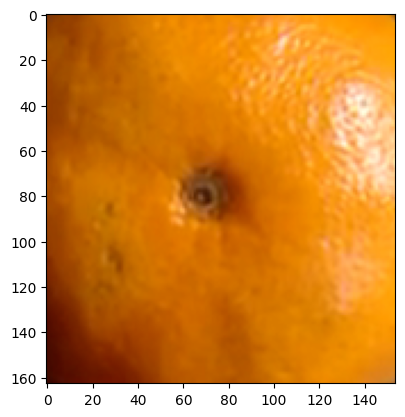

In [6]:
# load template
template = cv.imread(folder + template_file)
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)

# show template
plt.imshow(template)
plt.show()

In [7]:
from IPython.display import display, Image

video = cv.VideoCapture(folder + video_file)
display_handle=display(None, display_id=True)
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

## Detekce typu snímků

mp4 video obsahuje 3 typy snímků:
- I snímky (klíčové snímky) - obsahují kompletní informaci o scéně
- P snímky (predikované snímky) - obsahují informaci o změnách oproti předchozímu snímku
- B snímky (bi-predikované snímky) - obsahují informaci o změnách oproti předchozímu a následujícímu snímku

In [8]:
import subprocess

def get_frame_types(video_file):
    result = subprocess.run(
        ['ffprobe', '-select_streams', 'v', '-show_frames', '-show_entries', 'frame=pict_type', '-of', 'csv', video_file],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )
    frame_types = result.stdout.splitlines()
    return frame_types

video_path = folder + video_file
frame_types = get_frame_types(video_path)

print("Number of frames:", len(frame_types))

# Example usage
I_frames = []
frame_number = 0
for frame_type in frame_types:
    frame_number += 1
    if 'I' in frame_type:
        I_frames.append(frame_number)
        print(f'Frame {frame_number} is I-frame')
    elif 'P' in frame_type:
        #print(f'Frame {frame_number} is P-frame')
        pass
    elif 'B' in frame_type:
        #print(f'Frame {frame_number} is B-frame')
        pass

Number of frames: 272
Frame 1 is I-frame
Frame 72 is I-frame
Frame 202 is I-frame


## CamShift

In [9]:
def process_image(image):
    """ Process image
    """
    bgr = cv2.imread(image)

    # Plot
    plt.figure()
    plt.subplot(1, 3, 1)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)

    plt.subplot(1, 3, 2)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    plt.imshow(hsv)

    plt.subplot(1, 3, 3)
    hist = img2hue_histogram(bgr)
    plt.plot(hist)
    plt.title("Histogram")
    plt.xlabel("Hue")
    plt.ylabel("Count")

    plt.show()

    # picure size
    print("Image size: {0}".format(rgb.shape))

    plt.waitforbuttonpress()

In [10]:
plt.ion()
clear()
plt.close('all')

In [11]:
camshift = CamShift(folder + template_file)

# Zkontrolujte, zda soubor existuje
video_path = folder + video_file
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

# Pokus o otevření videa
video = cv.VideoCapture(video_path)
if not video.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")


display_handle=display(None, display_id=True)
frame_number = 0
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        
        frame_number += 1
        if frame_number > I_frames[1] and frame_number < I_frames[2]:
            green = (0, 255, 0)
            (x1, y1), (x2, y2) = camshift.next_positon(frame)

            cv.rectangle(frame, (x1, y1), (x2, y2), green)
        
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

print("Done")      


None

Done


## Background Subtraction

In [12]:
# vytazeni prvniho a 10 framu z videa
video_path = folder + video_file
frame_numbers = [0, 54]
frames = get_frames(video_path, frame_numbers)

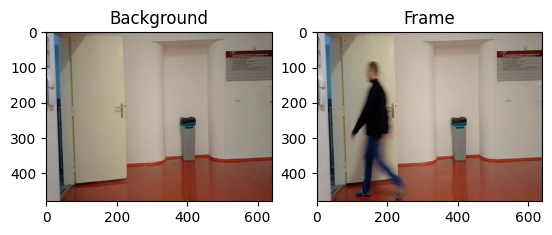

In [13]:
# zobrazeni snimku

background, frame = frames

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(background, cv.COLOR_BGR2RGB))
plt.title("Background")

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.title("Frame")

plt.show()

Final coordinates:
((np.int64(98), np.int64(86)), (np.int64(233), np.int64(477)))


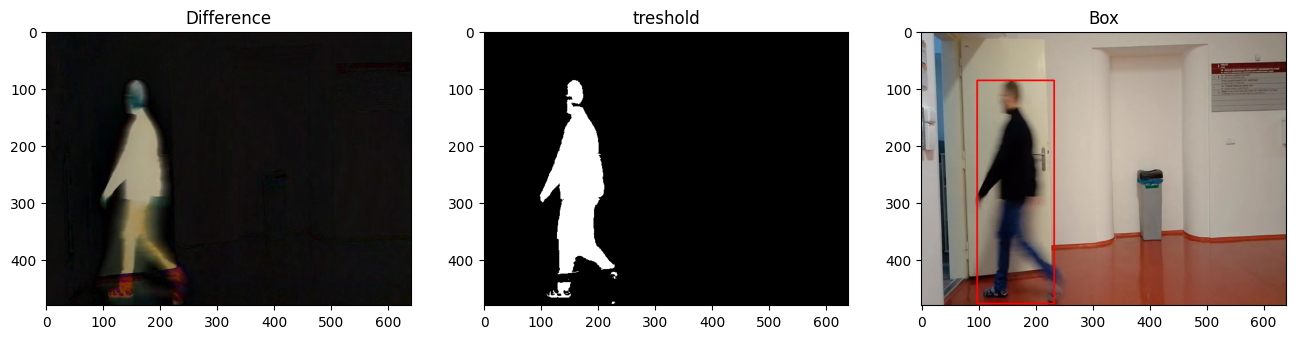

In [14]:
DEBUG = True
    
def create_box_coordinates_from_mask(mask):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    
    # remove last contour
    contours = contours[:-1]
    if DEBUG:
        for contour in contours:
            x, y, w, h = cv.boundingRect(contour)
            x1, y1 = x, y
            x2, y2 = x + w, y + h
            print(f"Box: ({x1}, {y1}), ({x2}, {y2})")

    # join all contours in one
    all_contours = np.concatenate(contours)
    
    # create bounding box around all contours
    x, y, w, h = cv.boundingRect(all_contours)
    return (x, y), (x + w, y + h)

# test
threshold = 50
background_subtraction = BackGroundSubtraction(background, threshold)
diff = background_subtraction.calculate_diff(frame)

# diff to grayscale
diff_mask = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)

# threshold
_, diff_mask = cv.threshold(diff_mask, threshold, 255, cv.THRESH_BINARY)

coordinates = background_subtraction.process(frame)

color = (0, 0, 255)
thickness = 2
print("Final coordinates:")
print(coordinates)
frame_with_box = frame.copy()
if coordinates is not None:
    (x1, y1), (x2, y2) = coordinates
    cv.rectangle(frame_with_box, (x1, y1), (x2, y2), color, thickness)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(diff, cv.COLOR_BGR2RGB))
plt.title("Difference")

plt.subplot(1, 3, 2)
plt.imshow(diff_mask, cmap='gray')
plt.title("treshold")

plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(frame_with_box, cv.COLOR_BGR2RGB))

plt.title("Box")
plt.show()

In [19]:
background_subtraction = None

# Zkontrolujte, zda soubor existuje
video_path = folder + video_file
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

# Pokus o otevření videa
video = cv.VideoCapture(video_path)
if not video.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")


display_handle=display(None, display_id=True)
frame_number = 0
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        
        frame_number += 1
        if frame_number > I_frames[1]:
            break

        if frame_number == 1:
            background = frame
            background_subtraction = BackGroundSubtraction(background)
            continue

        color = (0, 0, 255)
        thickness = 2
        coordinates = background_subtraction.process(frame)

        if coordinates is not None:
            (x1, y1), (x2, y2) = coordinates
            cv.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
        
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))

        # wait 
        time.sleep(0.1)
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

print("Done") 

None

Done


## Výsledek detekce

In [22]:
camshift = CamShift(folder + template_file)
background_subtraction = None

thickness = 2

# Zkontrolujte, zda soubor existuje
video_path = folder + video_file
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

# Pokus o otevření videa
video = cv.VideoCapture(video_path)
if not video.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")


display_handle=display(None, display_id=True)
frame_number = 0
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        
        frame_number += 1
        if frame_number in I_frames:
            background = frame
            background_subtraction = BackGroundSubtraction(background)
            continue

        if frame_number <= I_frames[1] or frame_number >= I_frames[2]:
            color = (0, 0, 255)
            coordinates = background_subtraction.process(frame)

            if coordinates is not None:
                (x1, y1), (x2, y2) = coordinates
                cv.rectangle(frame, (x1, y1), (x2, y2), color, thickness)

        if frame_number > I_frames[1] and frame_number < I_frames[2]:
            green = (0, 255, 0)
            (x1, y1), (x2, y2) = camshift.next_positon(frame)

            cv.rectangle(frame, (x1, y1), (x2, y2), green, thickness)
        
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

print("Done")      


None

Done
